# Spotify Data Visualization - Scott Berry

Load environmental variables for Spotify client

In [13]:
from dotenv import load_dotenv
import os

load_dotenv(dotenv_path='spotipy.env')
client_id=os.environ.get('SPOTIPY_CLIENT_ID')
client_secret=os.environ.get('SPOTIPY_CLIENT_SECRET')

Create Spotipy client

In [14]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

auth_manager = SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret)
spotify = spotipy.Spotify(auth_manager=auth_manager)

Let's check the Spotify client's ability to pull info.

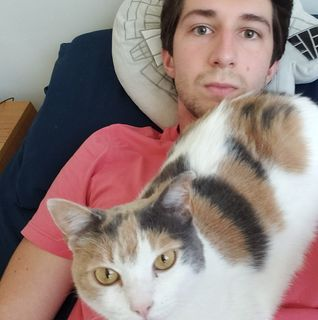

In [15]:
from PIL import Image
import requests

user_id = "12150189192" # This is retrieved via the "Account overview" page on Spotify
profile_pic_url = spotify.user(user_id)['images'][0]['url']
Image.open(requests.get(profile_pic_url, stream=True).raw)

We're definitely connected to the right Spotify account, this is myself and my cat. Maybe listening to Spotify at the time, no way of knowing that via the API though.

Now, let's check out what I've been listening to. For streaming history, this had to be requested ahead of time from Spotify, and I am loading via downloaded files.

In [16]:
import pandas as pd
from glob import glob

history_files = glob(os.path.join("spotify_data/", "StreamingHistory*.json"))
streams_df = (pd.read_json(f) for f in history_files)
spotify_streams = pd.concat(streams_df, ignore_index=True)

spotify_streams.head(6)

,endTime,artistName,trackName,msPlayed
0,2019–01–26 07:49,Slayer,Chemical Warfare,8850
1,2019–01–26 07:51,Yung Gravy,Martha Stewart,5678
2,2019–01–26 07:47,Yung Gravy,Knockout,2345
3,2019–01–26 07:53,Denzel Curry,SPEEDBOAT,9876
4,2019–01–26 07:55,Rage Against The Machine,Know Your Enemy,8510
5,2019–01–26 07:57,Yung Gravy,Martha Stewart,9876


We won't be using the `endTime` field and let's sort alphabetically.

In [17]:
spotify_streams = spotify_streams.drop(columns='endTime')
spotify_streams = spotify_streams.sort_values(by=['artistName', 'trackName'], ignore_index=True)

spotify_streams.head(6)

,artistName,trackName,msPlayed
0,Denzel Curry,SPEEDBOAT,9876
1,Rage Against The Machine,Know Your Enemy,8510
2,Slayer,Chemical Warfare,8850
3,Yung Gravy,Knockout,2345
4,Yung Gravy,Martha Stewart,5678
5,Yung Gravy,Martha Stewart,9876


Let's get the total listen time for each song by concatenation of listen time `msPlayed` for each duplicate track

In [18]:
for i, row in spotify_streams.iterrows():
    if i > 0:
        curr_artist = row['artistName']
        curr_track = row['trackName']
        prev_artist = spotify_streams.iloc[i-1]['artistName']
        prev_track = spotify_streams.iloc[i-1]['trackName']
        if curr_artist == prev_artist and curr_track == prev_track:
            spotify_streams.at[i, 'msPlayed'] += row['msPlayed']
            spotify_streams = spotify_streams.drop(index=i-1)

spotify_streams.head(6)

,artistName,trackName,msPlayed
0,Denzel Curry,SPEEDBOAT,9876
1,Rage Against The Machine,Know Your Enemy,8510
2,Slayer,Chemical Warfare,8850
3,Yung Gravy,Knockout,2345
5,Yung Gravy,Martha Stewart,19752


Now, let's just take my top 100 listened to songs for our audio analysis

In [19]:
spotify_streams = spotify_streams.sort_values(by='msPlayed', ascending=False).reset_index(drop=True).head(100)
spotify_streams.head()

,artistName,trackName,msPlayed
0,Yung Gravy,Martha Stewart,19752
1,Denzel Curry,SPEEDBOAT,9876
2,Slayer,Chemical Warfare,8850
3,Rage Against The Machine,Know Your Enemy,8510
4,Yung Gravy,Knockout,2345


We should now have unique instances of every song and its total time played in milliseconds.

Now, let's get song metadata via Spotipy API. To do so, we need the unique "Track ID" of each song.

In [20]:
for i, row in spotify_streams.iterrows():
    search_result = spotify.search(q="artist:\"{artist}\"+track:\"{track}\"".format(artist=row['artistName'], track=row['trackName']), type="track", limit=1)
    track_id = search_result['tracks']['items'][0]['id']
    spotify_streams.loc[i, 'trackID'] = track_id
spotify_streams.head(6)

,artistName,trackName,msPlayed,trackID
0,Yung Gravy,Martha Stewart,19752,3g7fAvrGvvgMUE35p2rSIL
1,Denzel Curry,SPEEDBOAT,9876,2FTOLKjQUswhpdMFq15Raf
2,Slayer,Chemical Warfare,8850,3u63uszxopzY7zQD2zou1r
3,Rage Against The Machine,Know Your Enemy,8510,1XTGyfJeMiZXrZ1W3NolcB
4,Yung Gravy,Knockout,2345,4KtoztbBnU8JkP96u0B8HQ


We can then use that track ID to request the audio analysis of each track.

Let's check the songs' volume by segment.

In [21]:
volume_data = pd.DataFrame(columns=["Artist", "Track", "Start", "Loudness"])

for _, row in spotify_streams.iterrows():
    segments = spotify.audio_analysis(row['trackID'])['segments']
    for segment in segments:
        data = [row['artistName'], row['trackName'], segment['start'], segment['loudness_start']]
        volume_data.loc[len(volume_data)] = data

volume_data.head()

,Artist,Track,Start,Loudness
0,Yung Gravy,Martha Stewart,0.00000,-60.000
1,Yung Gravy,Martha Stewart,0.23193,-60.000
2,Yung Gravy,Martha Stewart,0.60853,-26.680
3,Yung Gravy,Martha Stewart,0.97329,-27.059
4,Yung Gravy,Martha Stewart,1.08308,-22.782


Use Altair to plot line chart of all my favorites songs' loudness by segment

In [22]:
import altair as alt
alt.data_transformers.enable('default', max_rows=None)

alt.Chart(volume_data).mark_line().encode(
    x='Start',
    y='Loudness',
    color='Artist',
    strokeDash='Track',
)

alt.Chart(...)

Now I'm interested in how the tempo varies by section.

In [23]:
tempo_data = pd.DataFrame(columns=["Artist", "Track", "Start", "Tempo"])

for _, row in spotify_streams.iterrows():
    sections = spotify.audio_analysis(row['trackID'])['sections']
    for section in sections:
        data = [row['artistName'], row['trackName'], section['start'], section['tempo']]
        tempo_data.loc[len(tempo_data)] = data

tempo_data.head()

,Artist,Track,Start,Tempo
0,Yung Gravy,Martha Stewart,0.00000,157.265
1,Yung Gravy,Martha Stewart,12.40407,158.317
2,Yung Gravy,Martha Stewart,40.10637,157.932
3,Yung Gravy,Martha Stewart,48.83612,158.326
4,Yung Gravy,Martha Stewart,61.71543,158.117


Plot line chart of all my songs’ tempo by segment

In [24]:
alt.Chart(tempo_data).mark_line().encode(
    x='Start',
    y='Tempo',
    color='Artist',
    strokeDash='Track',
)

alt.Chart(...)